In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
import sklearn
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

## Loading in our data
We have four sets to try out:
 * No n-gram
 * Only POS ngram
 * Only word ngram
 * both POS and word ngrams

In [2]:
base_dir = '../data/features'

X_train_all = scipy.sparse.load_npz(os.path.join(base_dir, 'X_train_balanced_all.npz'))
X_test_all = scipy.sparse.load_npz(os.path.join(base_dir, "X_test_balanced_all.npz"))

X_train_pos = scipy.sparse.load_npz(os.path.join(base_dir, 'X_train_pos_only_balanced.npz'))
X_test_pos = scipy.sparse.load_npz(os.path.join(base_dir, "X_test_pos_only_balanced.npz"))

X_train_words = scipy.sparse.load_npz(os.path.join(base_dir, 'X_train_words_only_balanced.npz'))
X_test_words = scipy.sparse.load_npz(os.path.join(base_dir, "X_test_words_only_balanced.npz"))

X_train_none = scipy.sparse.load_npz(os.path.join(base_dir, 'X_train_no_ngram.npz'))
X_test_none = scipy.sparse.load_npz(os.path.join(base_dir, "X_test_no_ngram.npz"))

In [3]:
y_train = np.ravel(np.load('../data/features/y_train_balanced.npy'))
y_test = np.ravel(np.load('../data/features/y_test_balanced.npy'))

In [4]:
print(X_train_all.shape)
print(X_test_all.shape)

(119293, 20319)
(29526, 20319)


In [5]:
print(X_train_pos.shape)
print(X_test_pos.shape)

(119293, 18771)
(29526, 18771)


In [6]:
print(X_train_words.shape)
print(X_test_words.shape)

(119293, 2039)
(29526, 2039)


In [7]:
print(X_train_none.shape)
print(X_test_none.shape)

(119293, 491)
(29526, 491)


In [8]:
# Grid of potential parameters
# Based from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# to learn how to black-box grid-searches.

# param_grid = {
#     'n_estimators': [150, 300, 350, 400],
#     'max_depth': [100, 150, 200],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 5, 10],
#     'class_weight': ['balanced_subsample']
# }

In [9]:
# We use RandomizedSearch, but since our num_iters is larger than the possible combinations, it's effectively a grid search.

# random_forest = RandomForestClassifier()
# random_forest_randomized_search = RandomizedSearchCV(estimator=random_forest,
#                                                      param_distributions=param_grid,
#                                                      cv=3,
#                                                      n_iter=500,
#                                                      scoring='f1',
#                                                      n_jobs=6,
#                                                      verbose=3,
#                                                      random_state=15)

In [10]:
# random_forest_randomized_search.fit(X_train, y_train) # this was done on all features (including pos and words)

In [11]:
# random_forest_randomized_search.best_params_

Optimal params for our 80/20 split:
 * max_depth: 100
 * min_samples_leaf=10
 * min_samples_split': 2,
 * n_estimators: 300
 * class_weight: balanced_subsample

In [12]:
def create_random_forest_clf(X_train, y_train, X_test, y_test, depth=100):
    tuned_rf = RandomForestClassifier(
        max_depth=depth, # was 50 for full
        min_samples_leaf=10,
        min_samples_split= 2,
        n_estimators=300, # Was 200 for full
        n_jobs=-1, # to maximize computing power
        random_state=15,
        class_weight='balanced_subsample' # experimenting with weights
    )
    tuned_rf.fit(X_train, y_train)
    return tuned_rf

In [13]:
all_rf = create_random_forest_clf(X_train_all, y_train, X_test_all, y_test)
pos_rf = create_random_forest_clf(X_train_pos, y_train, X_test_pos, y_test)
words_rf = create_random_forest_clf(X_train_words, y_train, X_test_words, y_test)
none_rf = create_random_forest_clf(X_train_none, y_train, X_test_none, y_test, 25) # define depth as 25 here bc of the lack of features

In [14]:
all_predictions_train = all_rf.predict(X_train_all)
all_predictions_test = all_rf.predict(X_test_all)

pos_predictions_train = pos_rf.predict(X_train_pos)
pos_predictions_test = pos_rf.predict(X_test_pos)

words_predictions_train = words_rf.predict(X_train_words)
words_predictions_test = words_rf.predict(X_test_words)

none_predictions_train = none_rf.predict(X_train_none)
none_predictions_test = none_rf.predict(X_test_none)

In [15]:
all_probs_train = [x[1] for x in all_rf.predict_proba(X_train_all)]
all_probs_test = [x[1] for x in all_rf.predict_proba(X_test_all)]

pos_probs_train = [x[1] for x in pos_rf.predict_proba(X_train_pos)]
pos_probs_test = [x[1] for x in pos_rf.predict_proba(X_test_pos)]

words_probs_train = [x[1] for x in words_rf.predict_proba(X_train_words)]
words_probs_test = [x[1] for x in words_rf.predict_proba(X_test_words)]

none_probs_train = [x[1] for x in none_rf.predict_proba(X_train_none)]
none_probs_test = [x[1] for x in none_rf.predict_proba(X_test_none)]

In [16]:
def print_performance_stats(y_actual, y_predict):
    f1_score = sklearn.metrics.f1_score(y_actual, y_predict)
    precision = sklearn.metrics.precision_score(y_actual, y_predict)
    recall  = sklearn.metrics.recall_score(y_actual, y_predict)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_actual, y_predict)
    print("F1 Score: " + str(f1_score))
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("Confusion Matrix: " + str(confusion_matrix))
    

### Results

1. All Features

In [17]:
print('Training:')
print_performance_stats(y_train, all_predictions_train)
print('\n\nTesting:')
print_performance_stats(y_test, all_predictions_test)

Training:
F1 Score: 0.5316720283488741
Precision: 0.4369966713196607
Recall: 0.6787158640817177
Confusion Matrix: [[74335 20973]
 [ 7706 16279]]


Testing:
F1 Score: 0.3480431848852901
Precision: 0.2897752808988764
Recall: 0.4356418918918919
Confusion Matrix: [[17285  6321]
 [ 3341  2579]]


Training:
F1 Score: 0.5332726652257991
Precision: 0.4369407754580315
Recall: 0.6840942255576402
Confusion Matrix: [[74164 21144]
 [ 7577 16408]]


Testing:
F1 Score: 0.3488372093023256
Precision: 0.2896851975887475
Recall: 0.43834459459459457
Confusion Matrix: [[17243  6363]
 [ 3325  2595]]

2. Only POS

In [18]:
print('Training:')
print_performance_stats(y_train, pos_predictions_train)
print('\n\nTesting:')
print_performance_stats(y_test, pos_predictions_test)

Training:
F1 Score: 0.5361046057767369
Precision: 0.439484841212703
Recall: 0.6871794871794872
Confusion Matrix: [[74287 21021]
 [ 7503 16482]]


Testing:
F1 Score: 0.33422638981915603
Precision: 0.2769145394006659
Recall: 0.4214527027027027
Confusion Matrix: [[17091  6515]
 [ 3425  2495]]


Training:
F1 Score: 0.5354972869350488
Precision: 0.4386861508158322
Recall: 0.6871377944548677
Confusion Matrix: [[74220 21088]
 [ 7504 16481]]


Testing:
F1 Score: 0.3353028064992615
Precision: 0.27824827278805436
Recall: 0.42179054054054055
Confusion Matrix: [[17129  6477]
 [ 3423  2497]]

3. Only word n-grams

In [19]:
print('Training:')
print_performance_stats(y_train, words_predictions_train)
print('\n\nTesting:')
print_performance_stats(y_test, words_predictions_test)

Training:
F1 Score: 0.40868222424268663
Precision: 0.31251931311526066
Recall: 0.5903272878882635
Confusion Matrix: [[64161 31147]
 [ 9826 14159]]


Testing:
F1 Score: 0.35926055109870947
Precision: 0.273887608580039
Recall: 0.5219594594594594
Confusion Matrix: [[15414  8192]
 [ 2830  3090]]


Training:
F1 Score: 0.40868222424268663
Precision: 0.31251931311526066
Recall: 0.5903272878882635
Confusion Matrix: [[64161 31147]
 [ 9826 14159]]


Testing:
F1 Score: 0.35926055109870947
Precision: 0.273887608580039
Recall: 0.5219594594594594
Confusion Matrix: [[15414  8192]
 [ 2830  3090]]

4. No n-grams

In [20]:
print('Training:')
print_performance_stats(y_train, none_predictions_train)
print('\n\nTesting:')
print_performance_stats(y_test, none_predictions_test)

Training:
F1 Score: 0.3703403671522833
Precision: 0.269686013320647
Recall: 0.5908692933083177
Confusion Matrix: [[56930 38378]
 [ 9813 14172]]


Testing:
F1 Score: 0.34643084092353316
Precision: 0.2523141005862388
Recall: 0.5525337837837838
Confusion Matrix: [[13913  9693]
 [ 2649  3271]]


Training:
F1 Score: 0.3703403671522833
Precision: 0.269686013320647
Recall: 0.5908692933083177
Confusion Matrix: [[56930 38378]
 [ 9813 14172]]


Testing:
F1 Score: 0.34643084092353316
Precision: 0.2523141005862388
Recall: 0.5525337837837838
Confusion Matrix: [[13913  9693]
 [ 2649  3271]]

In [21]:
# ROC curve?

fpr_all_training, tpr_all_training, _ = sklearn.metrics.roc_curve(y_train, all_probs_train)
fpr_all_testing, tpr_all_testing, _ = sklearn.metrics.roc_curve(y_test, all_probs_test)

fpr_pos_training, tpr_pos_training, _ = sklearn.metrics.roc_curve(y_train, pos_probs_train)
fpr_pos_testing, tpr_pos_testing, _ = sklearn.metrics.roc_curve(y_test, pos_probs_test)

fpr_words_training, tpr_words_training, _ = sklearn.metrics.roc_curve(y_train, words_probs_train)
fpr_words_testing, tpr_words_testing, _ = sklearn.metrics.roc_curve(y_test, words_probs_test)

fpr_none_training, tpr_none_training, _ = sklearn.metrics.roc_curve(y_train, none_probs_train)
fpr_none_testing, tpr_none_testing, _ = sklearn.metrics.roc_curve(y_test, none_probs_test)

0.8095594442809684


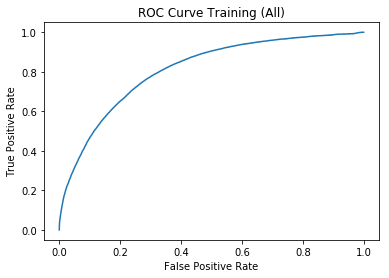

0.6262562763188929


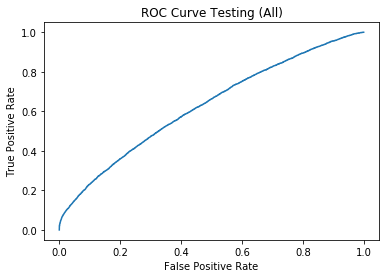

In [22]:
plt.plot(fpr_all_training, tpr_all_training)
print(sklearn.metrics.auc(fpr_all_training, tpr_all_training))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Training (All)')
plt.show()

plt.plot(fpr_all_testing, tpr_all_testing)
print(sklearn.metrics.auc(fpr_all_testing, tpr_all_testing))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Testing (All)')
plt.show()

0.8101935170516673


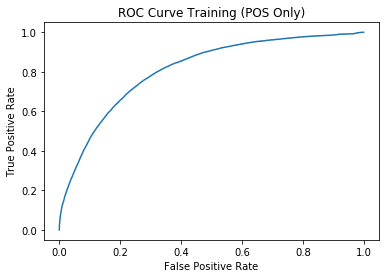

0.6078090151438824


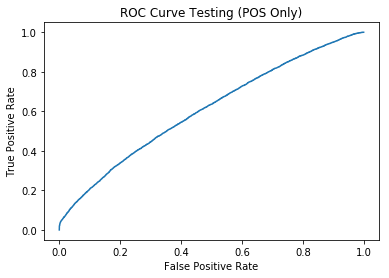

In [23]:
plt.plot(fpr_pos_training, tpr_pos_training)
print(sklearn.metrics.auc(fpr_pos_training, tpr_pos_training))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Training (POS Only)')
plt.show()

plt.plot(fpr_pos_testing, tpr_pos_testing)
print(sklearn.metrics.auc(fpr_pos_testing, tpr_pos_testing))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Testing (POS Only)')
plt.show()

0.6876632882296164


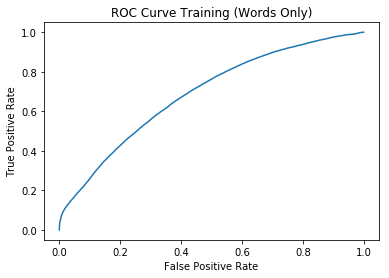

0.6281284526551885


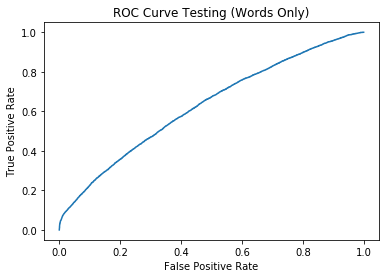

In [24]:
plt.plot(fpr_words_training, tpr_words_training)
print(sklearn.metrics.auc(fpr_words_training, tpr_words_training))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Training (Words Only)')
plt.show()

plt.plot(fpr_words_testing, tpr_words_testing)
print(sklearn.metrics.auc(fpr_words_testing, tpr_words_testing))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Testing (Words Only)')
plt.show()

0.6337785226369298


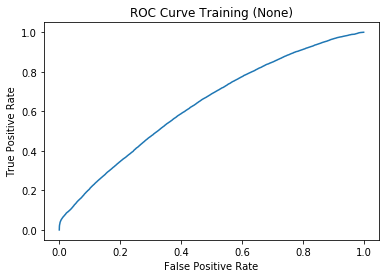

0.603466970290421


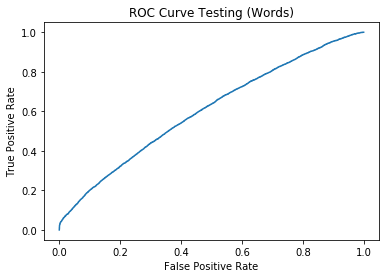

In [25]:
plt.plot(fpr_none_training, tpr_none_training)
print(sklearn.metrics.auc(fpr_none_training, tpr_none_training))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Training (None)')
plt.show()

plt.plot(fpr_none_testing, tpr_none_testing)
print(sklearn.metrics.auc(fpr_none_testing, tpr_none_testing))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Testing (Words)')
plt.show()

In [26]:
all_feat_importances = np.ndarray.tolist(all_rf.feature_importances_)

In [27]:
zipped_feat_importances = [x for x in zip(all_feat_importances, range(len(all_feat_importances)))]

In [28]:
zipped_feat_importances.sort(reverse=True, key=lambda x: x[0])

In [29]:
top_25_most_important = zipped_feat_importances[0:25]

In [30]:
top_25_most_important

[(0.025286556074498083, 0),
 (0.023967710630549446, 5),
 (0.023799667386940757, 2),
 (0.02264897929746557, 4),
 (0.020948729055812264, 3),
 (0.01505776989936599, 14),
 (0.012963675589078289, 35),
 (0.012436900854382886, 11),
 (0.01240941122783996, 9),
 (0.011012084851925182, 8),
 (0.010027122858933566, 164),
 (0.009808856772910874, 6),
 (0.009009460400303248, 7),
 (0.006582367129793536, 1),
 (0.006143788615623307, 13),
 (0.005263980529319652, 16),
 (0.004571123817062439, 22),
 (0.004533597928878329, 915),
 (0.004300474286432919, 624),
 (0.003706379766553755, 101),
 (0.0035058441338036298, 927),
 (0.002932238539715204, 1475),
 (0.0027167768484319095, 112),
 (0.0026236816739915684, 2745),
 (0.0024714291519252205, 644)]

In [31]:
# also known as...
feature_names = np.load('../data/features/all_features_arr.npy')

In [32]:
top_25_most_important_indices = [x[1] for x in top_25_most_important]

In [33]:
top_25_most_important_feature_names = []
for x in top_25_most_important_indices:
    top_25_most_important_feature_names.append(feature_names[x])

In [34]:
top_25_most_important_feature_names = [str(x) for x in top_25_most_important_feature_names]

Text(0.5, 1.0, 'Top 25 most important features and importance scores')

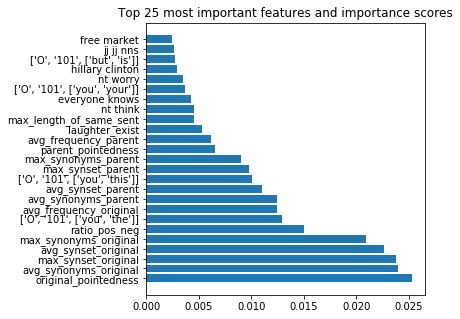

In [43]:
# Then plotting the most important things:
plt.figure(figsize=(5, 5))  # width:20, height:3
plt.barh(top_25_most_important_feature_names, [x[0] for x in top_25_most_important])
plt.title('Top 25 most important features and importance scores')

In [45]:
sklearn.metrics.accuracy_score(y_test, all_predictions_test)

0.6727629885524622